Importing and Downloading

In [1]:
!tar -xzf temp.tar.gz

In [2]:
!pip install scanpy

In [3]:
!mkdir data
!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir write

mkdir: cannot create directory ‘data’: File exists
--2021-04-26 11:06:55--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 104.18.0.173, 104.18.1.173, 2606:4700::6812:1ad, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz [following]
--2021-04-26 11:06:55--  https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|104.18.0.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  16.8MB/s    in 0.4s    

2021-04-26 11:06:5

In [4]:
import scanpy as sc
import numpy as np
import pandas as pd

In [5]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.19.5 scipy==1.4.1 pandas==1.1.5 scikit-learn==0.24.1 statsmodels==0.10.2


In [6]:
results_file = 'write/pbmc3k.h5ad'  # the file that will store the analysis results

In [7]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [8]:
adata.var_names_make_unique()

In [9]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [10]:
#BASIC FILTERING
sc.pp.filter_cells(adata, 200)
sc.pp.filter_genes(adata, 3)

adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

filtered out 18972 genes that are detected in less than 3 counts


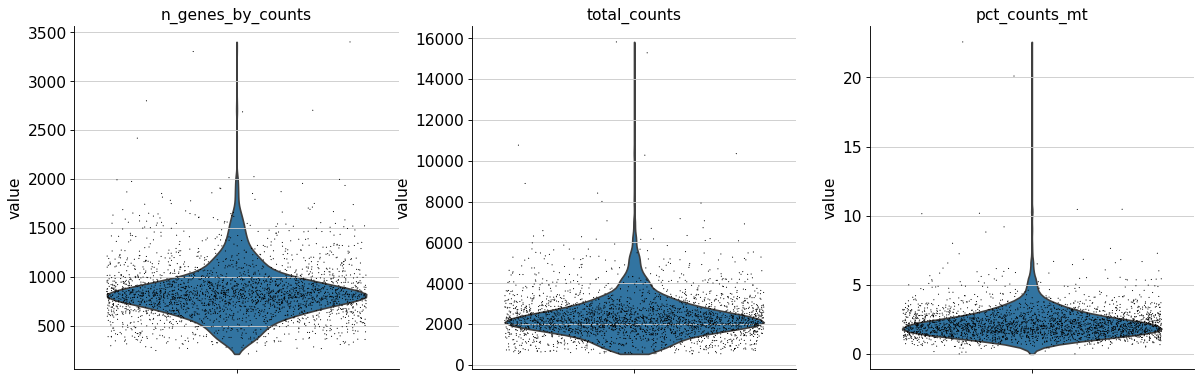

In [11]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [12]:
def preprocessing(adata, ngbclb, mtlb, ngbcub, mtub):
  
  #Remove cells that have too many mitochondrial genes expressed or too many total counts
  # adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
  # sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
  adata[adata.obs.n_genes_by_counts > ngbclb, :]
  adata[adata.obs.pct_counts_mt > mtlb, :]
  adata[adata.obs.n_genes_by_counts < ngbcub, :]
  adata[adata.obs.pct_counts_mt < mtub, :]
  
  #Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells.
  sc.pp.normalize_total(adata, target_sum=1e4)
  
  #Logarithmize the data
  sc.pp.log1p(adata)
  
  #Identify highly-variable genes.
  sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

  #Set the .raw attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object.
  adata.raw = adata
  
  #Doing the filtering
  adata = adata[:, adata.var.highly_variable]
  
 
  #Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
  sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
  
  # Scale each gene to unit variance. Clip values exceeding standard deviation 10.
  sc.pp.scale(adata, max_value=10)

  return adata

In [13]:
adata = preprocessing(adata,0,0,2000,7)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
    finished (0:00:06)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


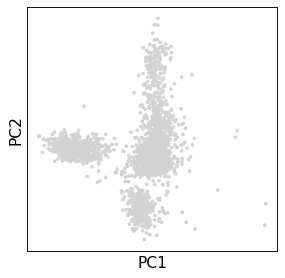

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)

In [ ]:
from PCA import *
from plot import *
from preprocessing import *

In [ ]:
ad = adata

In [15]:
sc.pp.highly_variable_genes(diadata, n_top_genes=1000, subset=True)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [ ]:
ad = ad.X

In [ ]:
import torch

In [ ]:
ad = torch.tensor(ad,device="cpu") 

In [ ]:
class PCA():

    def __init__(self,data,cuda: bool = True,max_components: int = 10, q: int = None ,center: bool = True, niter: int = 2, scaling: bool = True):
        
        self.data = data
        self.max_components = max_components
        self.q = q
        self.center = center
        self.niter = niter
        self.scaling = scaling
        self.shape = data.size()
        self.cuda = cuda
        if self.cuda:

            print("Using Cuda")
            torch.set_default_tensor_type(torch.cuda.DoubleTensor)

        else:

            torch.set_default_tensor_type(torch.DoubleTensor)

    def scale(self,data):

        scaler = StandardScaler(data)
        return scaler.forward()

    def PCA_rank(self,S):

        self.eigenvalues = torch.mul(S,S)/(self.shape[0]-1)
        self.sum_eigen_values = torch.sum(self.eigenvalues)

        self.PCs = []
        for i in range(1,self.eigenvalues.size()[0]+1):
            
            self.PCs += ['PC_'+str(i)]
        
        self.pc_rank = pd.DataFrame({'PC':self.PCs,'Proportion of Variance':self.eigenvalues.numpy()/self.sum_eigen_values})
            
        chart = rank_bar(self.pc_rank,'PCA','Proportion of Variance','PC')

    

    def forward(self,plot_rank: bool=True):
        
        if self.scaling:
            self.scale(self.data)

        
        self.U,self.S,self.V = torch.pca_lowrank(self.data, q = self.q, center = self.center, niter = self.niter)
        self.PCA_rank(self.S)
        result = torch.matmul(self.data,self.V[:, :self.max_components])
        return result

import torch

class StandardScaler():

    def __init__(self, data):

        self.data = data
        self.mean = data.mean(0, keepdim = True)
        self.std = data.std(0, unbiased = False, keepdim = True)
    
    def forward(self):

        self.data -= self.mean
        self.data /= self.std
        return self.data

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt 
import seaborn as sns


class rank_bar():

   
    def __init__(self, data, title = 'Plot', xaxis = "X-axis", yaxis = "y-axis", color_palette = 'summer'):
        
        self.data = data
        self.title = title
        self.xaxis = xaxis
        self.yaxis = yaxis
        self.color_palette = color_palette

        self.plot_chart()
    
    def plot_chart(self):

        plt.title(self.title)
        sns.barplot(x=self.xaxis, y=self.yaxis, data=self.data, palette=self.color_palette)
        plt.show()

In [ ]:
pca_scflash = PCA(ad,max_components =50)

Using Cuda


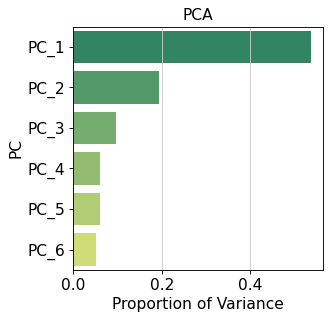

In [ ]:
pca_output= pca_scflash.forward()

In [ ]:
pca_output

tensor([[-0.9285,  3.4783,  0.2620, -1.6215,  0.3695, -0.1943],
        [ 0.0395,  1.5496, -2.4081, -1.0972, -1.5840,  0.7150],
        [-0.4774,  0.4636,  0.4549, -1.2768,  0.0252,  0.3416],
        ...,
        [-0.7095,  0.1083, -2.0399, -0.3930, -0.3892,  0.8772],
        [-0.9872,  0.7168,  0.4934, -0.8076, -0.1433, -0.1769],
        [-1.3210,  0.3660, -0.8413,  0.2334, -0.1488, -0.1763]], device='cpu',
       dtype=torch.float32)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


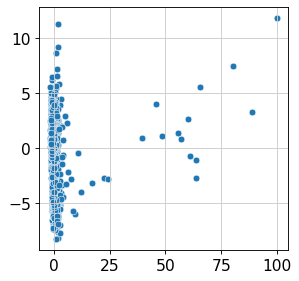

In [ ]:
import seaborn as sns
sns.scatterplot(pca_output[:,0],pca_output[:,1])

In [ ]:
from sklearn.decomposition import PCA 
pca_sk = PCA(n_components=50)
ad_sk = pca_sk.fit_transform(ad)

In [ ]:
ad_sk

array([[-0.9452731 ,  3.43323369, -0.75194726, ...,  1.73758597,
         1.19605871, -0.66726194],
       [-0.04393715,  1.89376276, -1.21543671, ...,  3.69888992,
         2.6960649 ,  1.10036009],
       [-0.43920155,  0.48794771,  1.34370102, ..., -0.38669429,
        -1.73104258,  2.37354144],
       ...,
       [-0.76776693,  0.42309625, -1.72099716, ...,  2.82735397,
        -0.05211581, -0.3813195 ],
       [-0.95834099,  0.71230001,  0.76574758, ..., -1.82125262,
         2.37640964,  1.50757725],
       [-1.32668834,  0.5072601 , -0.26755088, ...,  0.79785458,
         0.73657833,  1.16050143]])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


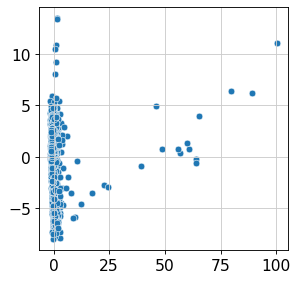

In [ ]:
sns.scatterplot(ad_sk[:,0],ad_sk[:,1])

In [14]:
diadata = adata

In [16]:
diadata

AnnData object with n_obs × n_vars = 2700 × 1000
    obs: 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

In [19]:
ls


cache/  data/  temp-kushan/  temp.tar.gz  write/


In [17]:
cd /content/temp-kushan

/content/temp-kushan


In [24]:
ls

Datasets/  Denoising/  Dim_reduction/  __init__.py  utils/


In [18]:
# !pip install pytorch_lightning
!pip install lightning-flash

In [40]:
!wget https://git.bayeslabs.co/KushanRaj/temp/-/blob/master/temp/utils/dataset.py

--2021-04-26 10:59:30--  https://git.bayeslabs.co/KushanRaj/temp/-/blob/master/temp/utils/dataset.py
Resolving git.bayeslabs.co (git.bayeslabs.co)... 35.188.6.199
Connecting to git.bayeslabs.co (git.bayeslabs.co)|35.188.6.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://git.bayeslabs.co/users/sign_in [following]
--2021-04-26 10:59:30--  https://git.bayeslabs.co/users/sign_in
Reusing existing connection to git.bayeslabs.co:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘dataset.py’

dataset.py              [ <=>                ]  11.43K  --.-KB/s    in 0s      

2021-04-26 10:59:30 (99.4 MB/s) - ‘dataset.py’ saved [11709]



In [20]:
from temp.utils.trainer import *
from temp.utils.scscopelightningnetwork import *
from temp.utils.dataset import *
from temp.Denoising.scScope import *

ModuleNotFoundError: ignored

In [26]:
gene_expression = diadata.copy()
gene_expression = gene_expression.X

In [31]:
model = LightningscScope(gene_expression.data, [], [], 64, exp_batch_input=[])

NameError: ignored

In [ ]:
ls